In [74]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import warnings

import geopandas as gpd
import geoplot as gplt
from adjustText import adjust_text

import cartopy
import cartopy.crs as ccrs
import networkx as nx

from matplotlib_inline.backend_inline import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

from pathlib import Path

## Meta data

In [4]:
meta_data = pd.read_excel('../metadata/Papio-Genomes_JR_120720_MR-CR-KM.xlsx')
meta_data.head()

PGDP_ID   Provider_ID          Provider          Genus Species  \
0  PD_0067          1043              Roos  Theropithecus  gelada   
1  PD_0199  09SNF1101115  Knauf/Chuma/Roos          Papio  anubis   
2  PD_0200  11SNF1101115  Knauf/Chuma/Roos          Papio  anubis   
3  PD_0201  19SNM1131115  Knauf/Chuma/Roos          Papio  anubis   
4  PD_0202  20SNF1131115  Knauf/Chuma/Roos          Papio  anubis   

                Origin Sex  
0              captive   M  
1  Serengeti, Tanzania   F  
2  Serengeti, Tanzania   F  
3  Serengeti, Tanzania   M  
4  Serengeti, Tanzania   F

Assign 'U' as unknown sex:

In [5]:
meta_data.loc[meta_data.Sex.isnull(), 'Sex'] = 'U'

Set https proxy. Jupyter does not inherrit the one set set for other shells.

In [6]:
# only use this on the cluster:
#%env https_proxy=http://in:3128 

Automacially retrieve geolocations:

In [23]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="baboon_map")
geolocations = dict()
unidentifiable = set()
for loc in meta_data.Origin:
    geoloc = geolocator.geocode(loc)
    if geoloc:
        geolocations[loc] = geoloc
    else:
        unidentifiable.add(loc)

Unidentifiable locations:

In [24]:
unidentifiable

{'Dendro Park, Zambia',
 'Filoha, Ethiopia',
 'Gog Woreda, Gambella region, Ethiopia',
 'Issa Valley, Tanzania'}

Get the last ones manually...

In [66]:
class dummy_geo():
    def __init__(self, *args, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)
manual_geolocations = dict()
manual_geolocations['Dendro Park, Zambia'] = dummy_geo(
    address='Dendro Balla Balla Safaris, Namwala, Zambia', 
    latitude=-16.145437871122923, longitude=26.062549952570674)
manual_geolocations['Filoha, Ethiopia'] = dummy_geo(
    address='Awash National Park in Ethiopia', 
    latitude=9.083582259300927, longitude=40.00000536178701)
manual_geolocations['Gog Woreda, Gambella region, Ethiopia'] = dummy_geo(
    address='Gambrella National Park, Ethiopia', 
    latitude=8.07396896853714, longitude=34.17906287308874)
manual_geolocations['Issa Valley, Tanzania'] = dummy_geo(
    address='Issa Valley, Tanzania', 
    latitude=-5.1204349934663025, longitude=30.625806814352387)

Add manual geolocations:

In [67]:
geolocations.update(manual_geolocations)

Augment meta data with geolocations:

In [68]:
meta_data['address'] = [geolocations[loc].address for loc in meta_data.Origin]                                      
meta_data['longitude'] = [geolocations[loc].longitude for loc in meta_data.Origin]                                      
meta_data['latitude'] = [geolocations[loc].latitude for loc in meta_data.Origin]                                                           

In [69]:
meta_data.head()

PGDP_ID   Provider_ID          Provider          Genus Species  \
0  PD_0067          1043              Roos  Theropithecus  gelada   
1  PD_0199  09SNF1101115  Knauf/Chuma/Roos          Papio  anubis   
2  PD_0200  11SNF1101115  Knauf/Chuma/Roos          Papio  anubis   
3  PD_0201  19SNM1131115  Knauf/Chuma/Roos          Papio  anubis   
4  PD_0202  20SNF1131115  Knauf/Chuma/Roos          Papio  anubis   

                Origin Sex                                            address  \
0              captive   M  German Captive soldiers, Գյումրի, Ախուրյանի տա...   
1  Serengeti, Tanzania   F  Serengeti National Park, Ikoma, Serengeti, Mar...   
2  Serengeti, Tanzania   F  Serengeti National Park, Ikoma, Serengeti, Mar...   
3  Serengeti, Tanzania   M  Serengeti National Park, Ikoma, Serengeti, Mar...   
4  Serengeti, Tanzania   F  Serengeti National Park, Ikoma, Serengeti, Mar...   

   longitude   latitude  
0  43.836979  40.778500  
1  34.701855  -2.369082  
2  34.701855  -2.369082  
3  34.701855  -2.369082  
4  34.701855  -2.369082

In [70]:
meta_data.to_excel('../metadata/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')

In [77]:
meta_data = pd.read_excel('../metadata/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')

## Colors

In [31]:
#mycols = sns.color_palette(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00','#6a3d9a', 'deeppink'])
mycols = sns.color_palette(['#33a02c', '#FFB100', "#8d9da3", '#1f78b4', '#e31a1c', '#b15928'])
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.2, 0.6274509803921569, 0.17254901960784313),
 (1.0, 0.6941176470588235, 0.0),
 (0.5529411764705883, 0.615686274509804, 0.6392156862745098),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

## Baboon range data

In [32]:
geodata_dir = Path('../baboon_range_data')
ranges_gdf = pd.concat(gpd.read_file(path) for path in geodata_dir.glob('**/*.shp'))


## Map data

In [33]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
world.columns

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')

In [34]:
world_midres = gpd.read_file(
    '../natural_earth/50m_cultural/ne_50m_admin_0_countries.shp'
)
world_midres.columns
world_midres['continent'] = world_midres.CONTINENT
world_midres['name'] = world_midres.NAME_EN

In [35]:
world.name.unique().size, world_midres.name.unique().size

(177, 241)

In [36]:
world.total_bounds.round().tolist()

[-180.0, -90.0, 180.0, 84.0]

/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


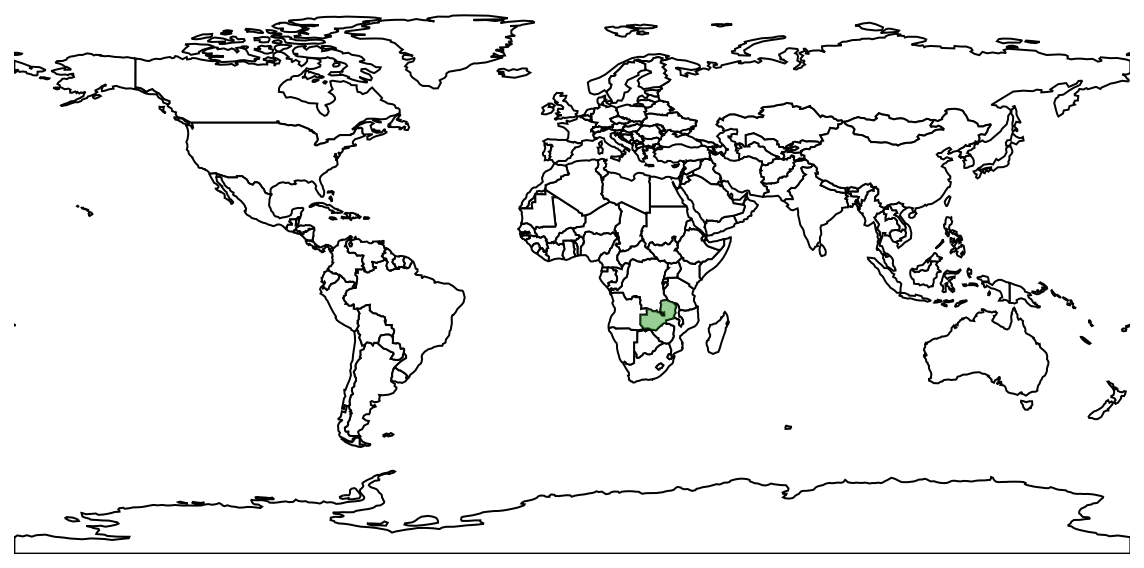

In [37]:
ax = gplt.polyplot(world,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    world.loc[world.name == 'Zambia'], hue='name', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, cmap=mycols_cmap, extent=world.total_bounds.round()
) ;


In [38]:
# africa = world[world.continent == 'Africa']
africa = world[(world.continent == 'Africa') | (world.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]
africa_midres = world_midres[(world_midres.continent == 'Africa') | (world_midres.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]

In [39]:
africa.name.unique().size, africa_midres.name.unique().size

(59, 62)

## Clean map

/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


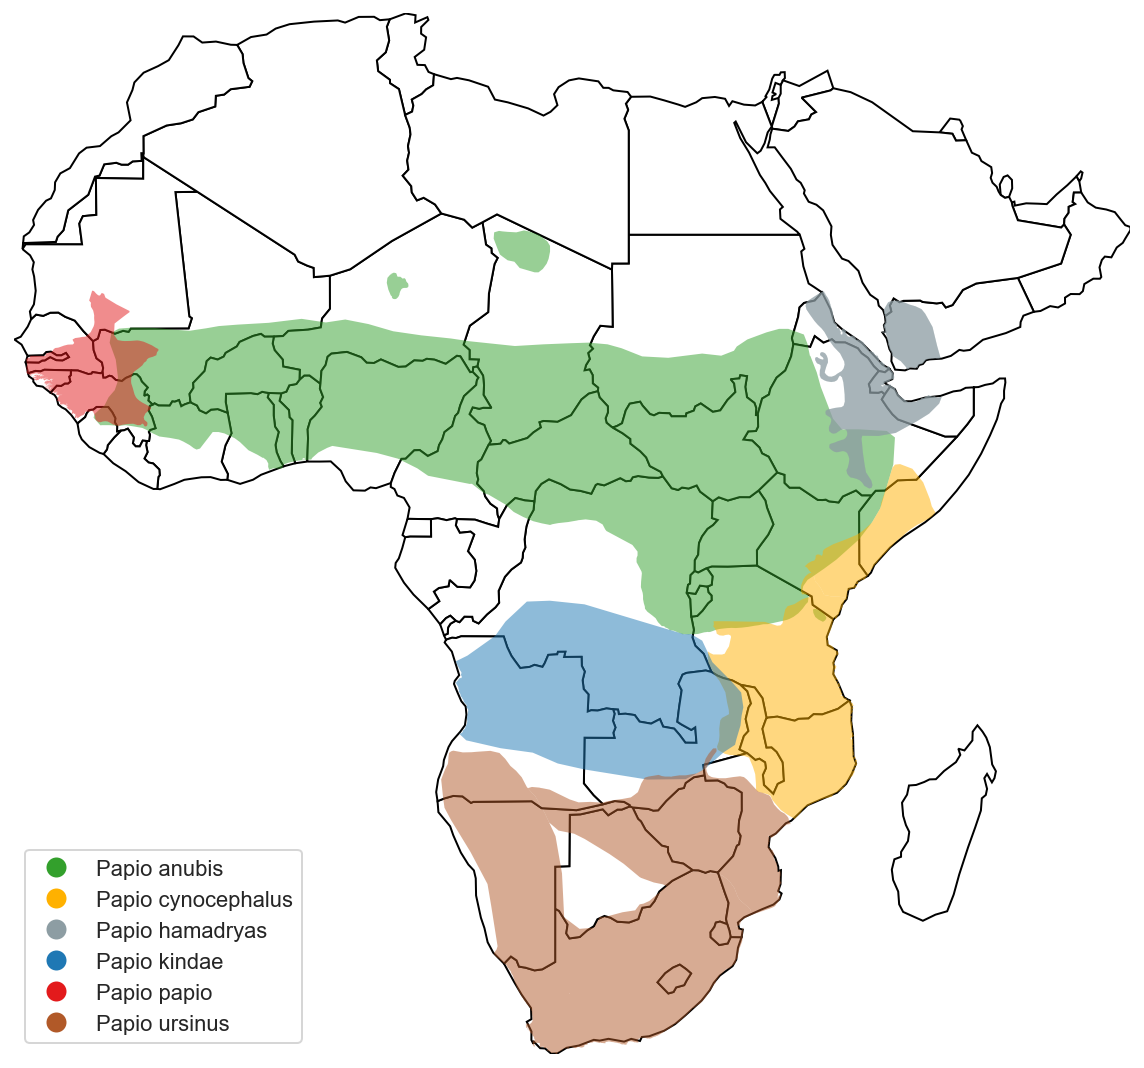

In [40]:
# world.loc[world.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
#                            'Israel', 'Jordan', 'Qatar', 'Kuwait'])]

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
plt.savefig('../figures/ranges.pdf')

## GeoDataFrame

In [41]:
gdf = gpd.GeoDataFrame(meta_data, geometry=gpd.points_from_xy(meta_data.longitude, meta_data.latitude)).loc[lambda df: df.Species != 'gelada']
gdf.loc[gdf.Species == 'ursinus (grayfoot)', 'Species'] = 'ursinus'
gdf.head()

Unnamed: 0  PGDP_ID   Provider_ID          Provider  Genus Species  \
1           1  PD_0199  09SNF1101115  Knauf/Chuma/Roos  Papio  anubis   
2           2  PD_0200  11SNF1101115  Knauf/Chuma/Roos  Papio  anubis   
3           3  PD_0201  19SNM1131115  Knauf/Chuma/Roos  Papio  anubis   
4           4  PD_0202  20SNF1131115  Knauf/Chuma/Roos  Papio  anubis   
5           5  PD_0203  21SNF1151115  Knauf/Chuma/Roos  Papio  anubis   

                Origin Sex                                            address  \
1  Serengeti, Tanzania   F  Serengeti National Park, Ikoma, Serengeti, Mar...   
2  Serengeti, Tanzania   F  Serengeti National Park, Ikoma, Serengeti, Mar...   
3  Serengeti, Tanzania   M  Serengeti National Park, Ikoma, Serengeti, Mar...   
4  Serengeti, Tanzania   F  Serengeti National Park, Ikoma, Serengeti, Mar...   
5  Serengeti, Tanzania   F  Serengeti National Park, Ikoma, Serengeti, Mar...   

   longitude  latitude                   geometry  
1  34.701855 -2.369082  POINT (34.70185 -2.36908)  
2  34.701855 -2.369082  POINT (34.70185 -2.36908)  
3  34.701855 -2.369082  POINT (34.70185 -2.36908)  
4  34.701855 -2.369082  POINT (34.70185 -2.36908)  
5  34.701855 -2.369082  POINT (34.70185 -2.36908)

## Sampling locations for each species

/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


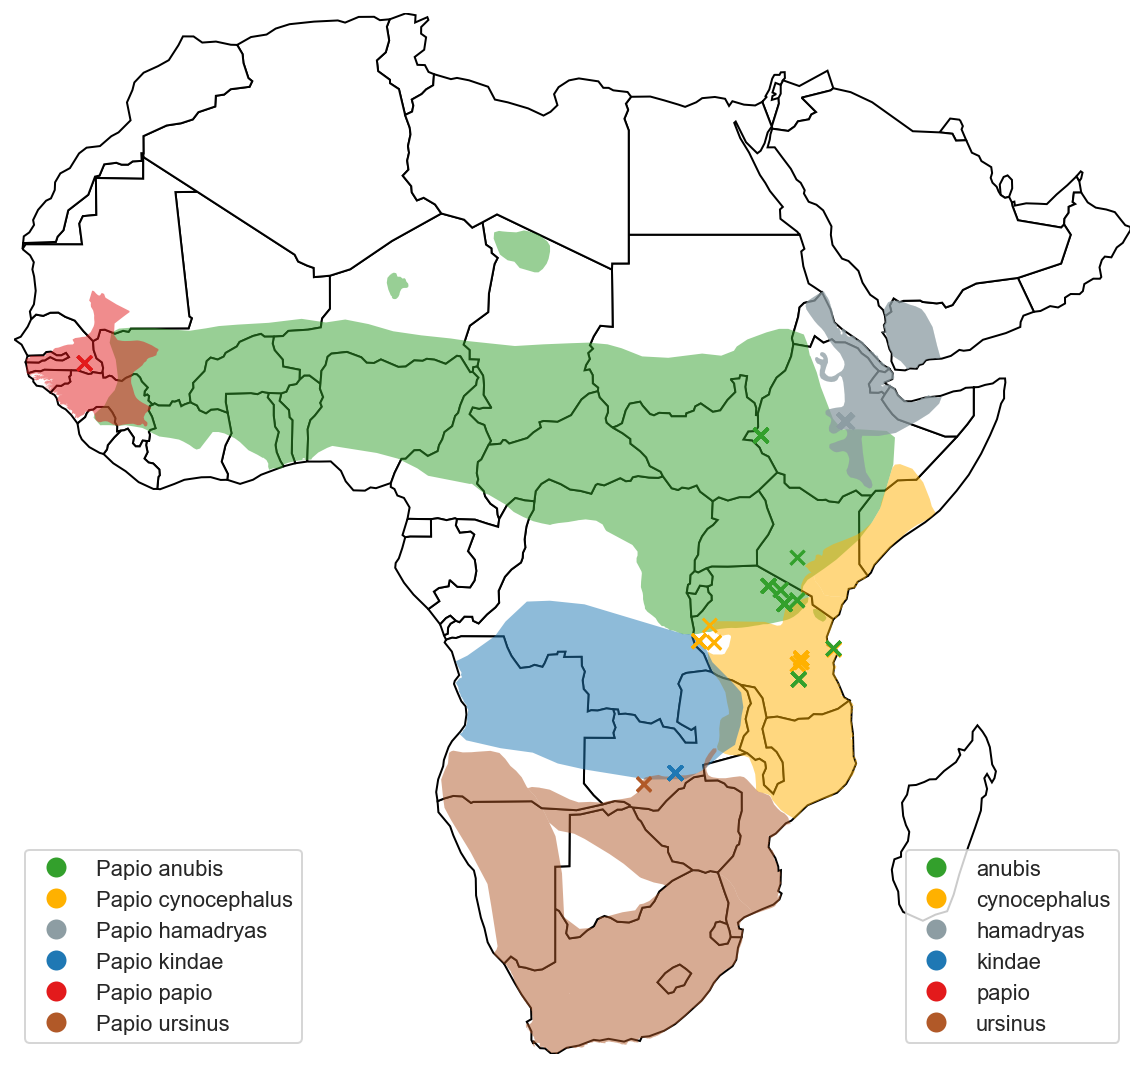

In [42]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

# overwrites first legend
gplt.pointplot(gdf, ax=ax, extent=africa.total_bounds, marker='x',
               zorder=10, s=7, hue='Species', legend=True, cmap=mycols_cmap, 
              legend_kwargs=dict(loc='lower right'));

# manually add the first legend back
ax.add_artist(leg1); 

## Plot with each sample as male or female

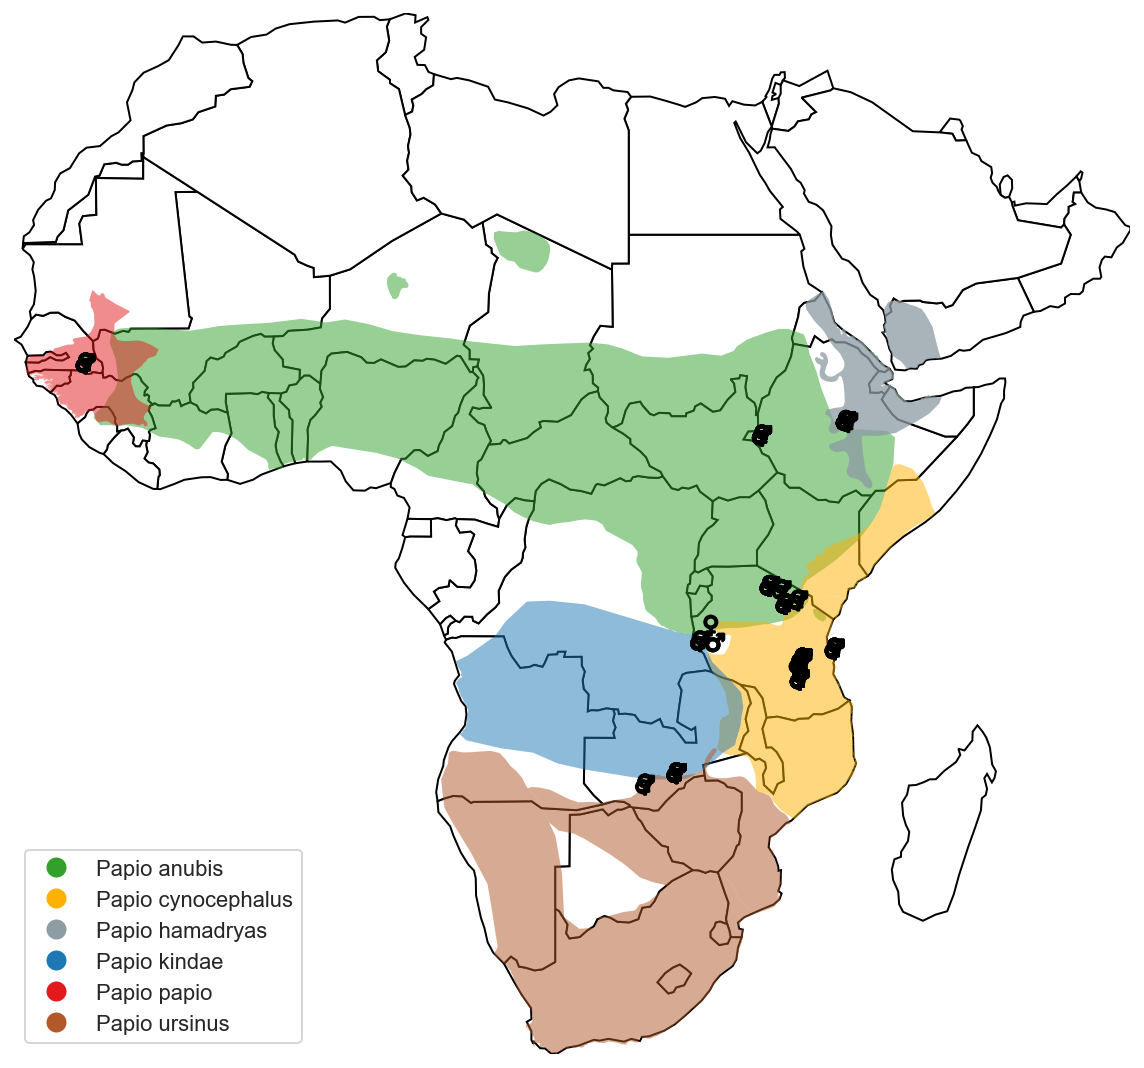

In [43]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;

gplt.pointplot(gdf.loc[gdf.Sex=='F'], ax=ax, extent=africa.total_bounds, marker="$\u2640$",
               zorder=10, s=10, color='black');
gplt.pointplot(gdf.loc[gdf.Sex=='M'], ax=ax, extent=africa.total_bounds, marker="$\u2642$",
               zorder=10, s=10, color='black');

In [44]:
gdf['dummy'] = np.random.random(gdf.index.size)

/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


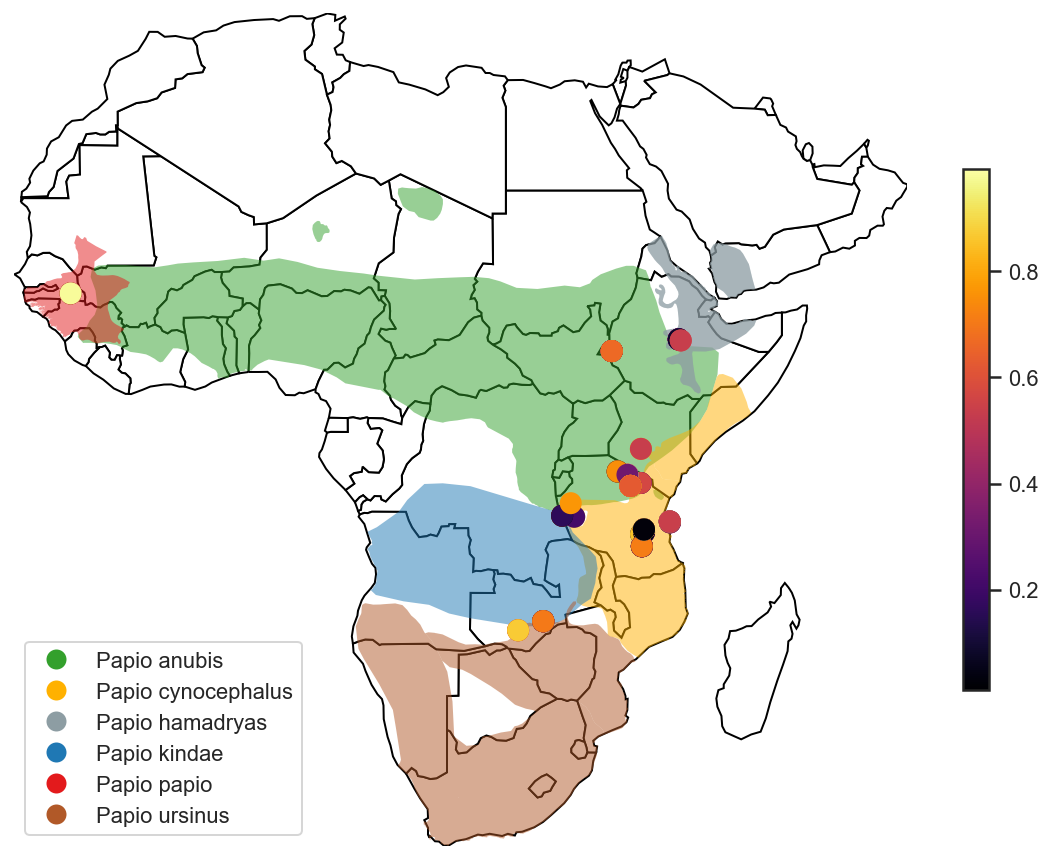

In [45]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;

gplt.pointplot(gdf, ax=ax, extent=africa.total_bounds, marker='o', #scheme=None,
               zorder=10, s=10, hue='dummy', legend=True, 
               legend_kwargs=dict(shrink=0.4), 
               cmap='inferno');

## Numbers of samples at each location

In [46]:
geo_loc = (gdf[['Origin', 'Species', 'Sex', 'geometry']]
           .dissolve(by=["Origin", 'Species'], 
                     aggfunc='count').rename(columns={'Sex': 'nr_samples'})
           .reset_index()
          )
geo_loc

Origin       Species  \
0                         Aberdare, Kenya        anubis   
1                        Arusha, Tanzania        anubis   
2                         Awash, Ethiopia     hamadryas   
3                          Chunga, Zambia        kindae   
4                     Dendro Park, Zambia       ursinus   
5                        Filoha, Ethiopia     hamadryas   
6   Gog Woreda, Gambella region, Ethiopia        anubis   
7                         Gombe, Tanzania        anubis   
8                   Issa Valley, Tanzania  cynocephalus   
9                        Katavi, Tanzania  cynocephalus   
10                 Lake Manyara, Tanzania        anubis   
11                       Mahale, Tanzania  cynocephalus   
12                       Mikumi, Tanzania  cynocephalus   
13                   Ngorongoro, Tanzania        anubis   
14                  Niokolo-Koba, Senegal         papio   
15                        Ruaha, Tanzania  cynocephalus   
16                       Selous, Tanzania  cynocephalus   
17                    Serengeti, Tanzania        anubis   
18                    Tarangire, Tanzania        anubis   
19                     Udzungwa, Tanzania  cynocephalus   
20                                captive        anubis   
21                                captive         papio   
22                                captive       ursinus   

                      geometry  nr_samples  
0    POINT (36.71245 -0.41025)           2  
1    POINT (36.68808 -3.36968)           4  
2     POINT (40.16767 8.99250)           2  
3   POINT (28.24438 -15.35811)          28  
4   POINT (26.06255 -16.14544)           4  
5     POINT (40.00001 9.08358)          24  
6     POINT (34.17906 8.07397)          25  
7    POINT (36.79745 -8.85799)          17  
8    POINT (30.62581 -5.12043)           1  
9    POINT (30.92783 -6.30155)           2  
10   POINT (35.80649 -3.62221)          19  
11   POINT (29.88343 -6.20329)           7  
12   POINT (36.97703 -7.40485)          38  
13   POINT (35.54565 -2.65253)           6  
14  POINT (-12.74834 13.07808)          12  
15   POINT (36.98286 -7.65658)           6  
16   POINT (39.23522 -6.78703)           3  
17   POINT (34.70185 -2.36908)          14  
18   POINT (39.21105 -6.70436)           7  
19   POINT (36.72583 -7.80331)           5  
20   POINT (43.83698 40.77850)           2  
21   POINT (43.83698 40.77850)           2  
22   POINT (43.83698 40.77850)           2

/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


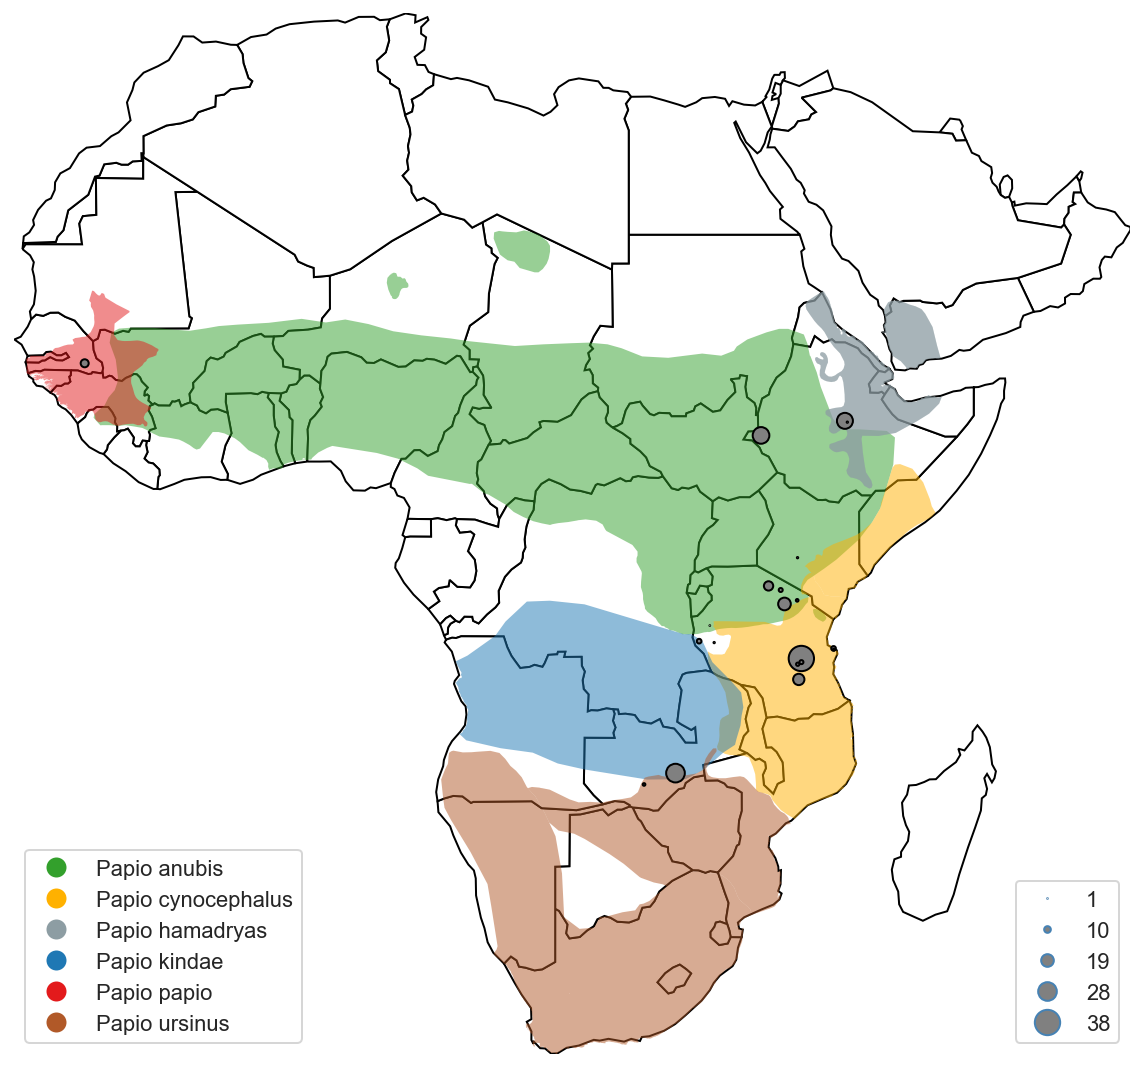

In [47]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 3
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right'),
              );

# manually add the first legend back
ax.add_artist(leg1); 

## Numbers of males sampled at each location

In [48]:
geo_loc = (gdf.loc[gdf.Sex == 'M', ['Origin', 'Species', 'Sex', 'geometry']]
           .dissolve(by=["Origin", 'Species'], 
                     aggfunc='count').rename(columns={'Sex': 'nr_samples'})
           .reset_index()
          )
geo_loc

Origin       Species  \
0                        Arusha, Tanzania        anubis   
1                         Awash, Ethiopia     hamadryas   
2                          Chunga, Zambia        kindae   
3                     Dendro Park, Zambia       ursinus   
4                        Filoha, Ethiopia     hamadryas   
5   Gog Woreda, Gambella region, Ethiopia        anubis   
6                         Gombe, Tanzania        anubis   
7                        Katavi, Tanzania  cynocephalus   
8                  Lake Manyara, Tanzania        anubis   
9                        Mahale, Tanzania  cynocephalus   
10                       Mikumi, Tanzania  cynocephalus   
11                   Ngorongoro, Tanzania        anubis   
12                  Niokolo-Koba, Senegal         papio   
13                        Ruaha, Tanzania  cynocephalus   
14                       Selous, Tanzania  cynocephalus   
15                    Serengeti, Tanzania        anubis   
16                    Tarangire, Tanzania        anubis   
17                     Udzungwa, Tanzania  cynocephalus   
18                                captive        anubis   
19                                captive         papio   

                      geometry  nr_samples  
0    POINT (36.68808 -3.36968)           2  
1     POINT (40.16767 8.99250)           1  
2   POINT (28.24438 -15.35811)          19  
3   POINT (26.06255 -16.14544)           1  
4     POINT (40.00001 9.08358)          19  
5     POINT (34.17906 8.07397)          17  
6    POINT (36.79745 -8.85799)           7  
7    POINT (30.92783 -6.30155)           2  
8    POINT (35.80649 -3.62221)           4  
9    POINT (29.88343 -6.20329)           5  
10   POINT (36.97703 -7.40485)          24  
11   POINT (35.54565 -2.65253)           1  
12  POINT (-12.74834 13.07808)           7  
13   POINT (36.98286 -7.65658)           2  
14   POINT (39.23522 -6.78703)           2  
15   POINT (34.70185 -2.36908)           6  
16   POINT (39.21105 -6.70436)           3  
17   POINT (36.72583 -7.80331)           2  
18   POINT (43.83698 40.77850)           1  
19   POINT (43.83698 40.77850)           1

/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


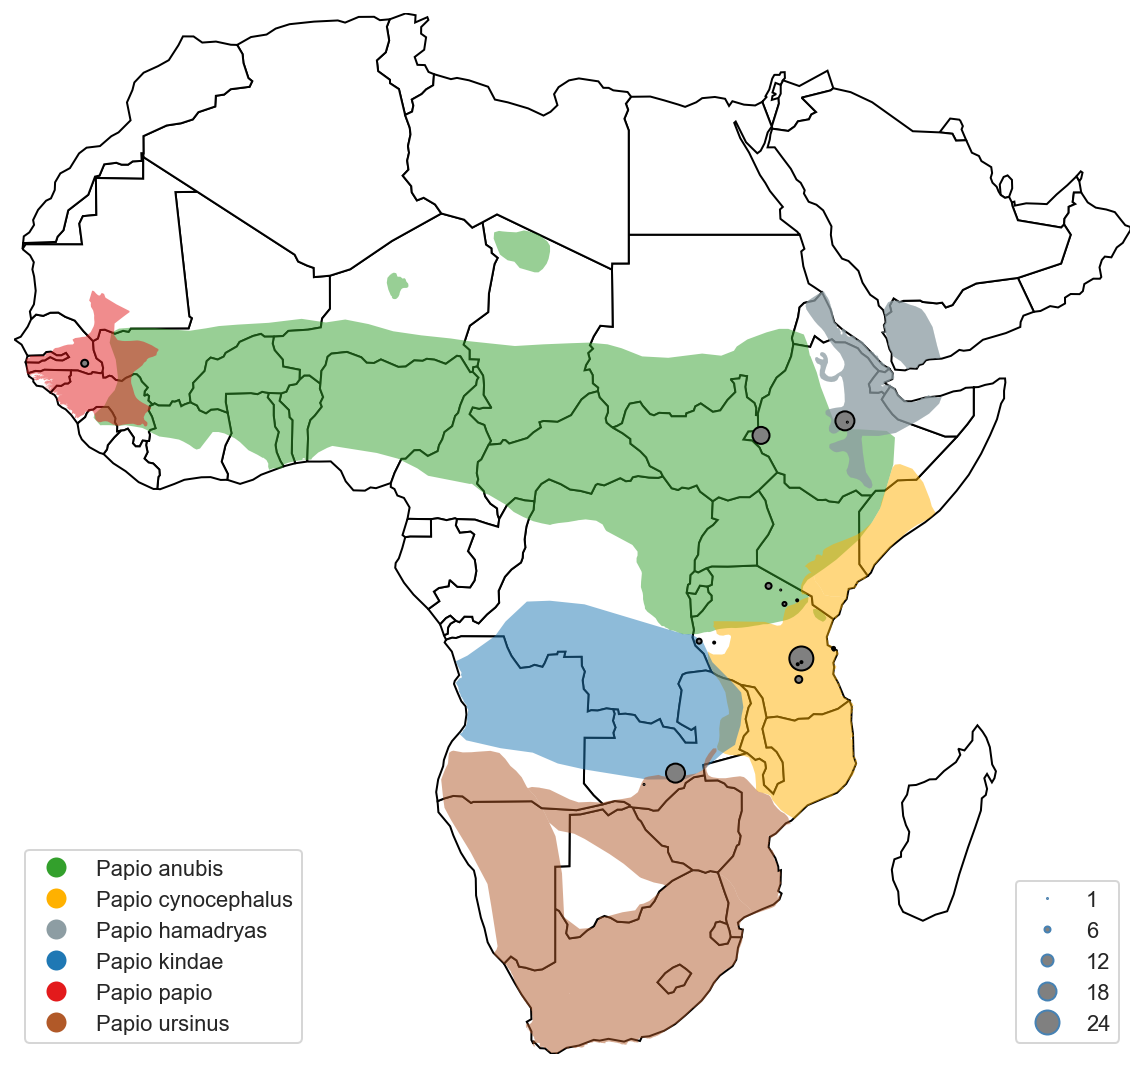

In [49]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 2
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right'),
              );

# manually add the first legend back
ax.add_artist(leg1); 

/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:1004: Sh

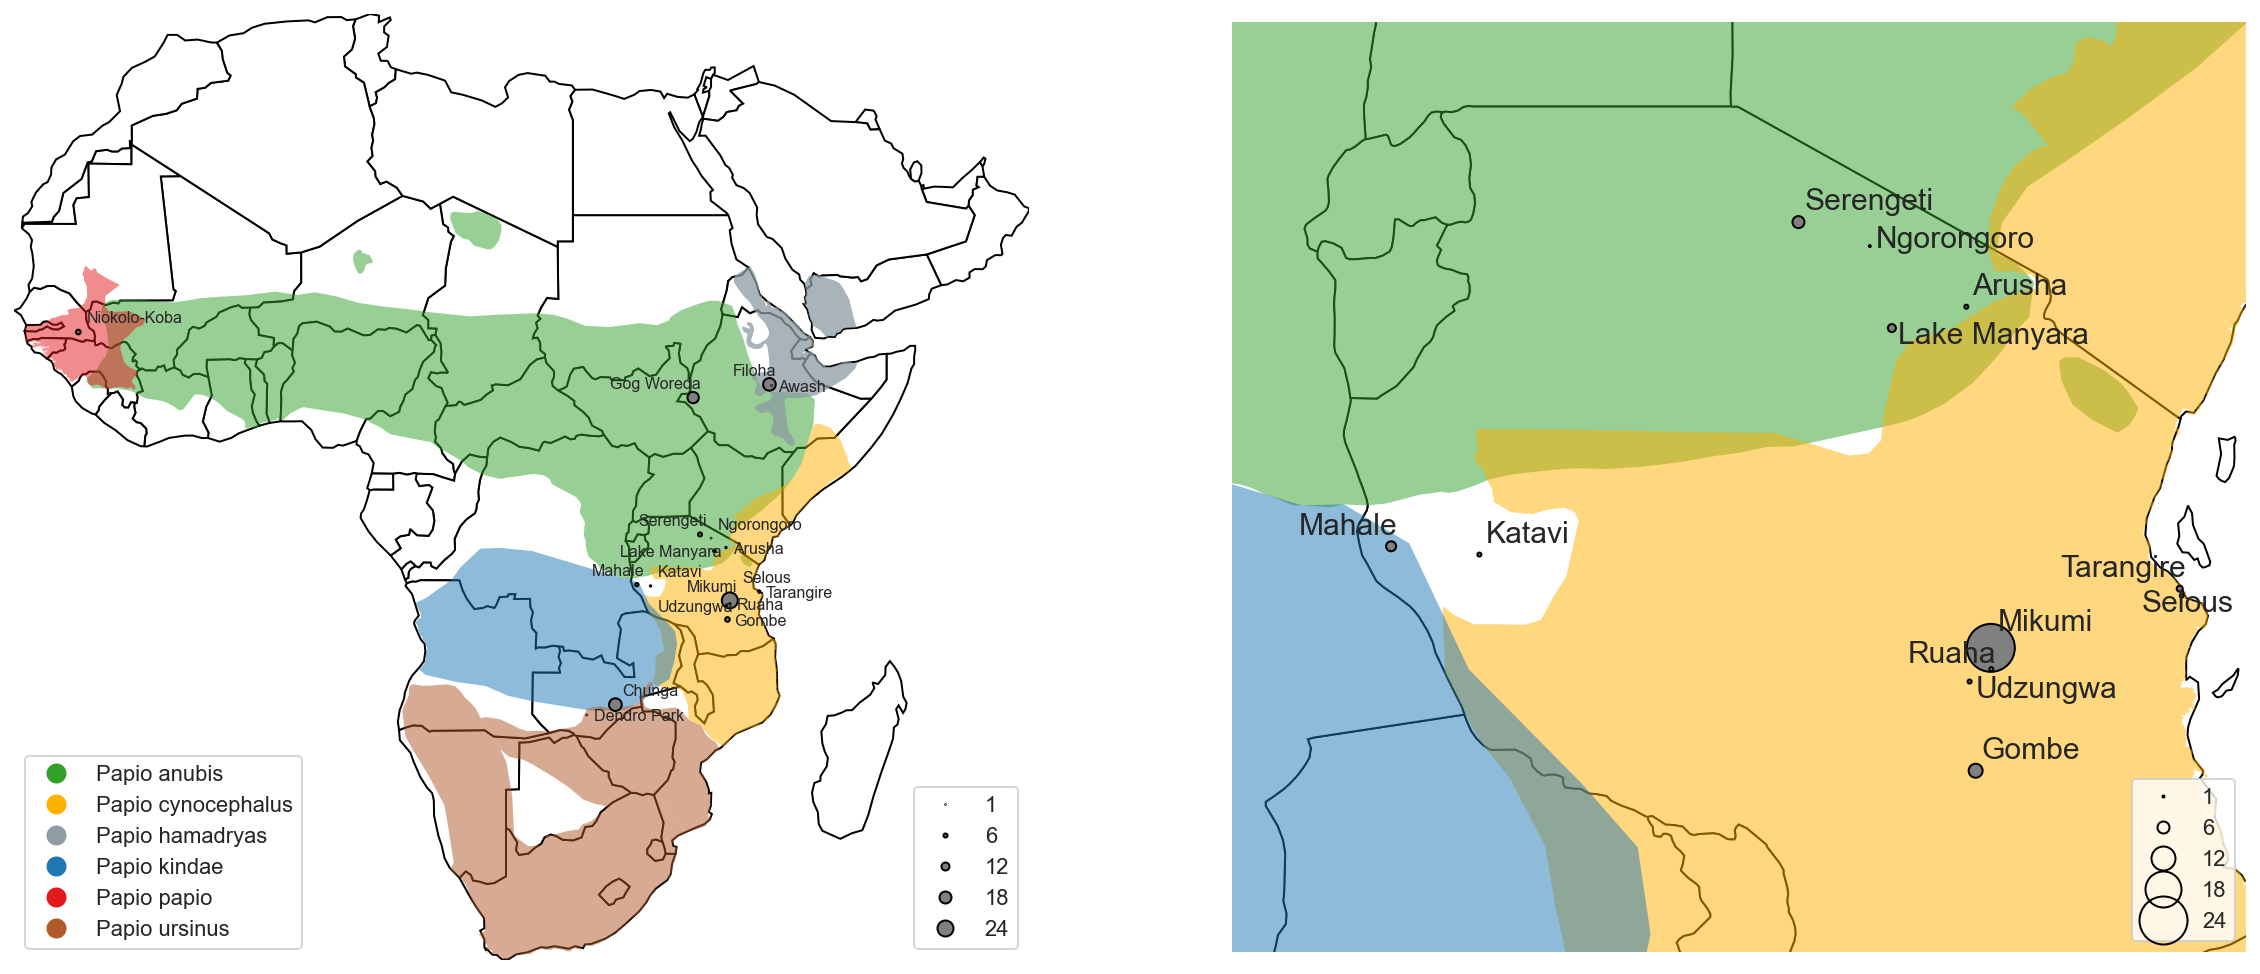

In [50]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 12))


ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', ax=ax)
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 3
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right', markeredgecolor='black'),
              );

texts = []
for x, y, label in zip(geo_loc.geometry.x, geo_loc.geometry.y, [x.split(',')[0] for x in geo_loc.Origin]):
    texts.append(ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", zorder=10, size=8))
adjust_text(texts)
    
# manually add the first legend back
ax.add_artist(leg1); 


ax = gplt.polyplot(africa_midres,
    facecolor='white', edgecolor='black', ax=ax2)
ax.set_facecolor('white')

extent = (28, -11, 40, 0)

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax2, 
    extent=extent,
    cmap=mycols_cmap, legend=True,
) ;
# get legend
leg1 = ax2.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax2, extent=extent,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right', markeredgecolor='black', markerfacecolor='none'),
              );

texts = []
for x, y, label in zip(geo_loc.geometry.x, geo_loc.geometry.y, [x.split(',')[0] for x in geo_loc.Origin]):
    if extent[0] < x < extent[2] and extent[1] < y < extent[3]:
        texts.append(ax2.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", zorder=10, size=15))
adjust_text(texts)        

plt.savefig('../figures/baboon_samples.pdf')

/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


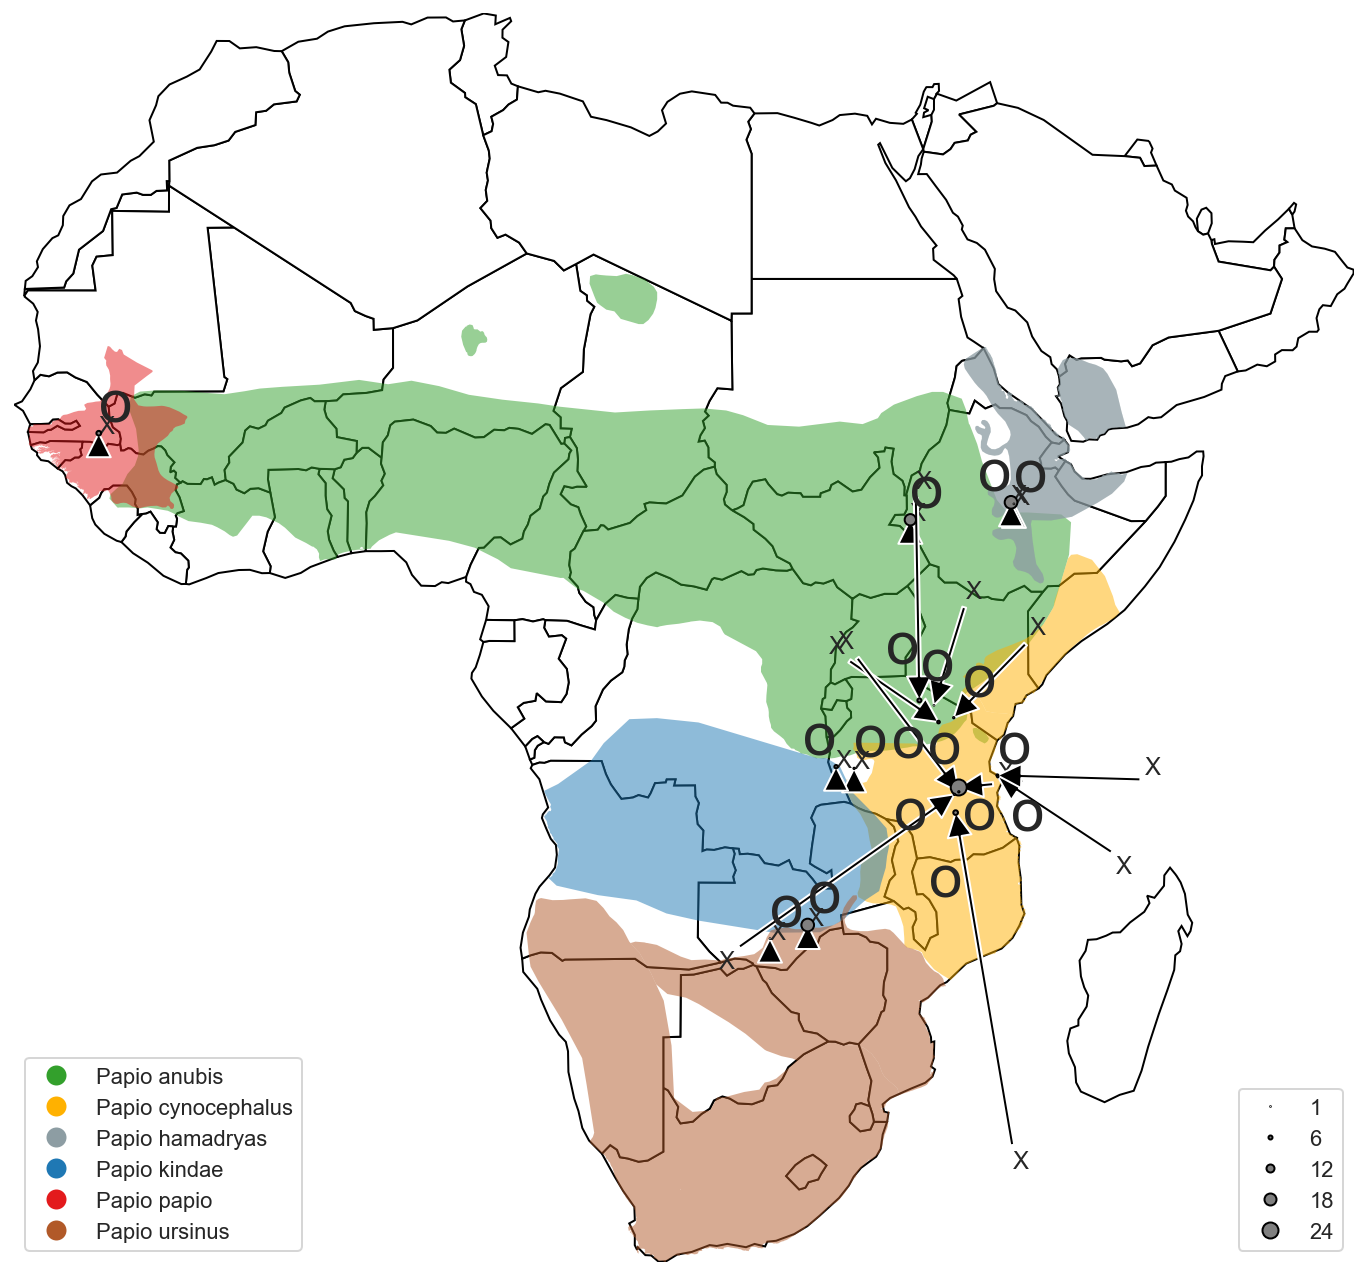

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))


ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', ax=ax)
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 3
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right', markeredgecolor='black'),
              );

texts = []
for x, y, label in zip(geo_loc.geometry.x, geo_loc.geometry.y, [x.split(',')[0] for x in geo_loc.Origin]):
    texts.append(ax.annotate("o", xy=(x, y), xytext=(0, 0), 
                             textcoords="offset points", 
                             zorder=10, size=30))
adjust_text(texts)
    
# manually add the first legend back
ax.add_artist(leg1); 


pos = list(zip(geo_loc.geometry.x, geo_loc.geometry.y))
offsets = [x.get_position() for x in texts]
for ((x, y), (a, b)) in zip(pos, offsets):
    ax.annotate("X", xy=(x, y), xytext=(x+a, y+b), 
           arrowprops=dict(facecolor='black', width=2))

In [52]:
texts

[Text(4.405495283603704, 4.812087957924913, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(3.319555498550316, -20.5237019549268, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(-6.334952196234513, 4.00219775863372, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(2.24555625193118, 0.5082019734139376, 'o'),
 Text(1.8284019681575785, 6.220335015657739, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(-6.997007422791067, 8.284989821171678, 'o'),
 Text(6.843130250703692, -5.56598640954563, 'o'),
 Text(-0.21164343469327207, 12.257265434204847, 'o'),
 Text(8.53009689675818, 0.048623424115213254, 'o'),
 Text(-13.628633095985819, -10.044013020649613, 'o'),
 Text(12.492101186622268, 14.133608566358951, 'o'),
 Text(12.492101186622268, 14.133608566358951, 'o')]

/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


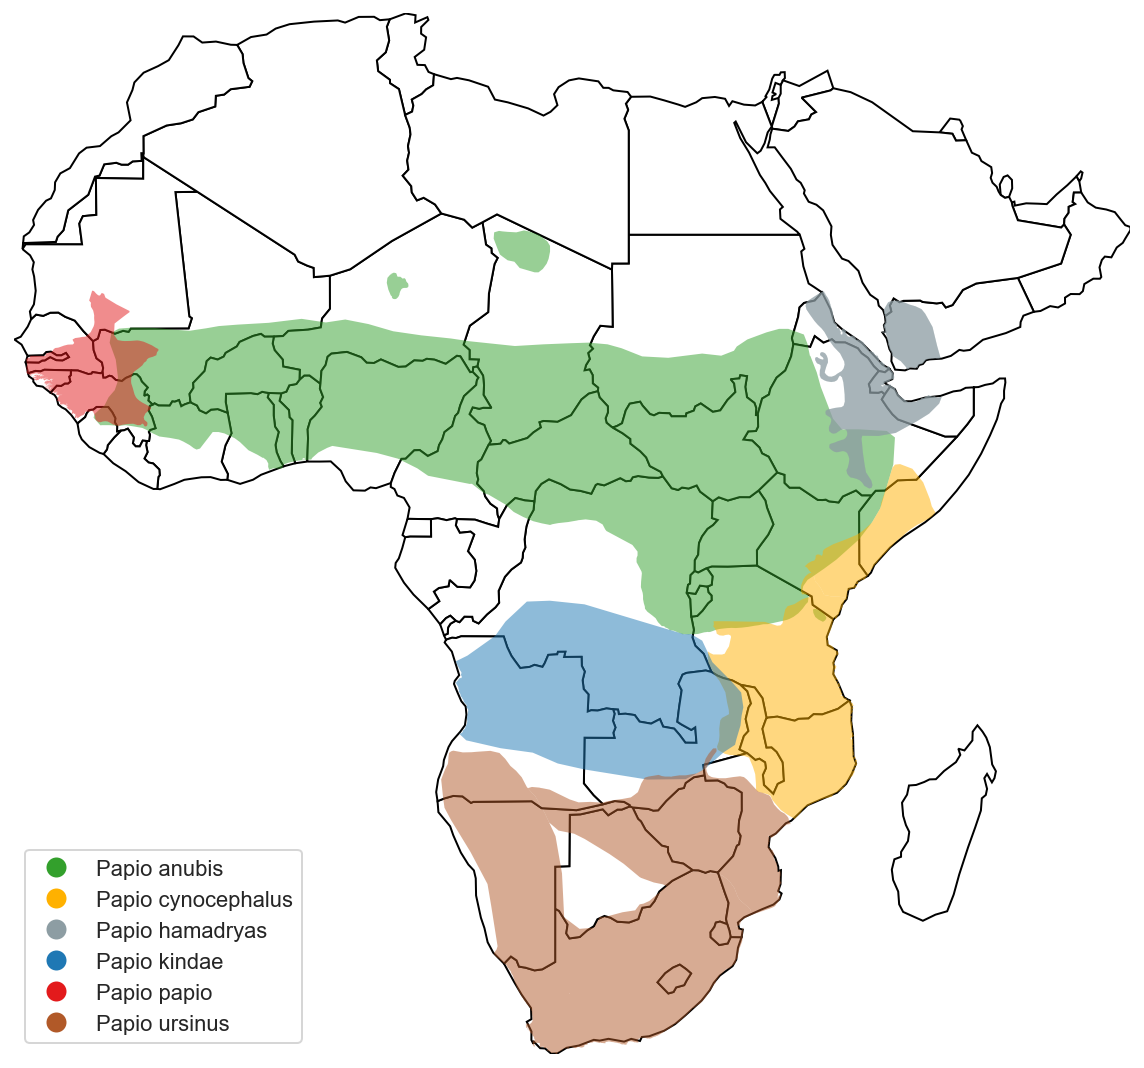

In [53]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;


import cartopy.crs as ccrs


# # overwrites first legend
# gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
#                zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
#                color='grey',
#                #fillstyle='none', 
# #                scatter_kws = {'fillstyle':'none'},
#                edgecolors='black',
#                legend_kwargs=dict(loc='lower right'),
#               );

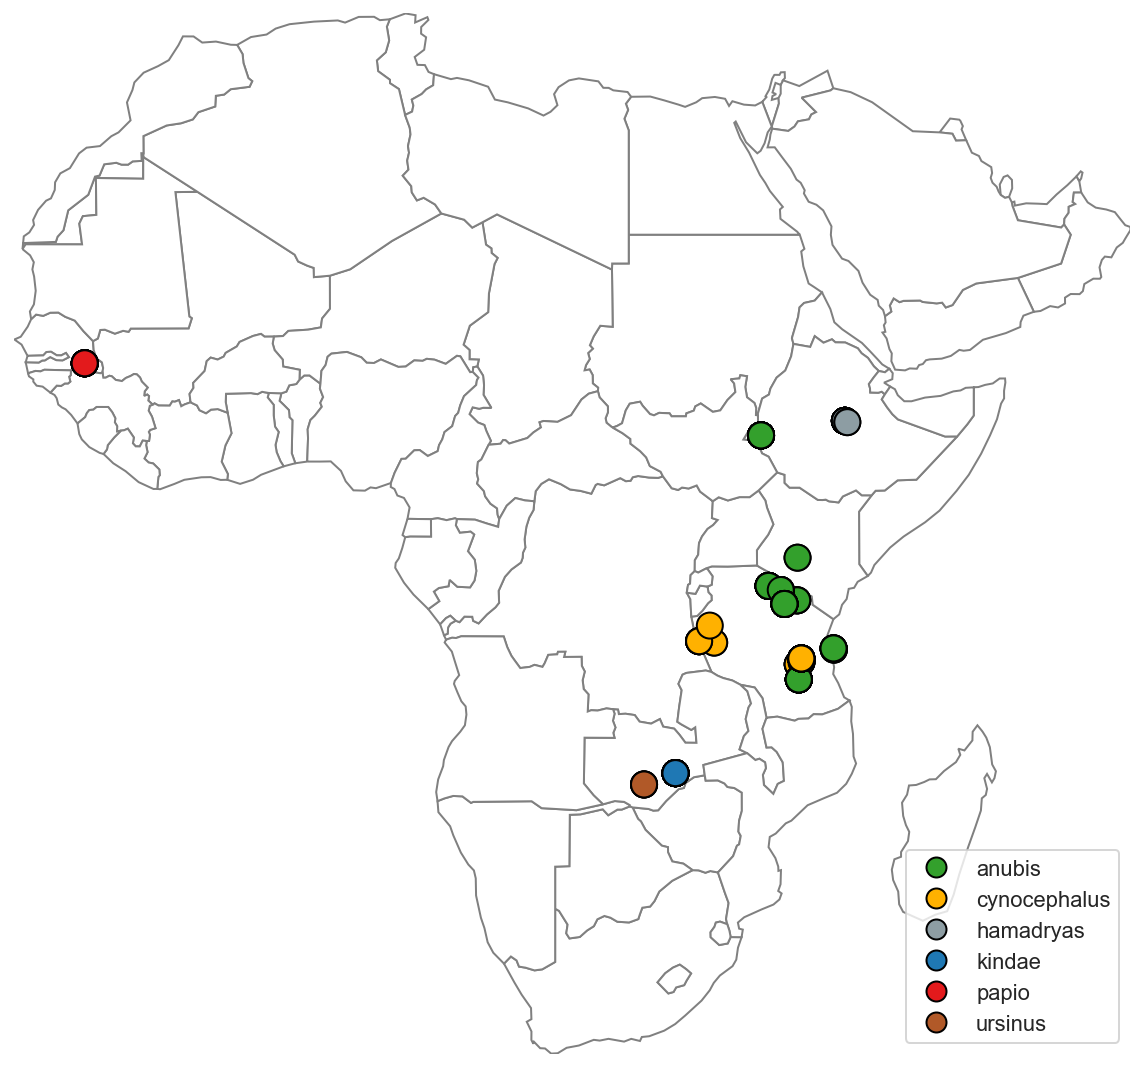

In [54]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='grey', figsize=(10, 12))
ax.set_facecolor('white')

# overwrites first legend
ax = gplt.pointplot(gdf, ax=ax, extent=africa.total_bounds, 
                marker='o', linewidth=1, edgecolor='black',
#               marker='x',
               zorder=10, s=13, hue='Species', legend=True, cmap=mycols_cmap, 
              legend_kwargs=dict(loc='lower right'));


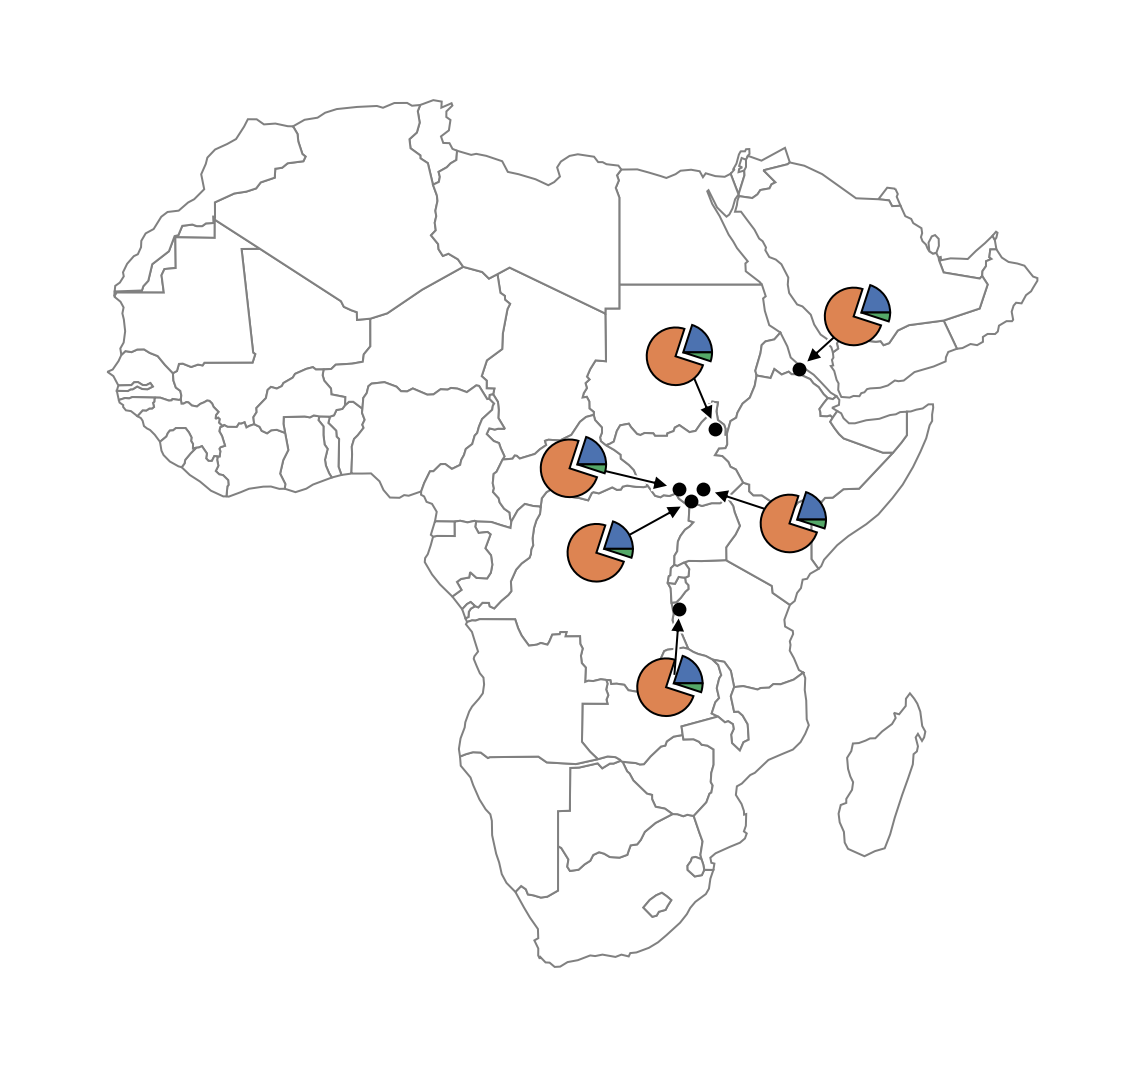

In [57]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import mpl_toolkits.axes_grid1.axes_size as Size


def plot_pie_inset(data,ilon,ilat,ax,width,lon_offset=0, lat_offset=0):
    
    if lon_offset or lat_offset:
        ax.scatter(ilon, ilat, color='black', zorder=50, s=35)

    ax_sub= inset_axes(ax, width=width, height=width, loc=10, 
                       bbox_to_anchor=(ilon+lon_offset, ilat+lat_offset),
                       bbox_transform=ax.transData, 
                       borderpad=0)

    if lon_offset or lat_offset:
#        ax.plot([ilon, ilon+lon_offset], [ilat, ilat+lat_offset], color='black', zorder=50, linestyle='dashed')
#         ax.arrow(ilon, ilat, lon_offset, lat_offset, color='black', zorder=100, linestyle='dashed', 
#                  length_includes_head=False, 
#                  head_starts_at_zero=True, 
#                  head_width=1)
        ax.annotate("", xy=(ilon,ilat), xytext=(ilon+lon_offset,ilat+lat_offset), 
                    arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=8, shrink=.1))
    
    wedges,texts= ax_sub.pie(data, 
                             explode=(0, 0.3, 0), 
                             startangle=0,
                             wedgeprops={"edgecolor":"black", 'linewidth': 1})

    ax_sub.set_aspect("equal")

    
def get_pie_posistions(lon_lat_coord, ax, k=None, seed=None):
    
    xy_coords = [ax.transData.transform(coord) for coord in lon_lat_coord]
    
    G = nx.Graph()
    nodes = range(len(xy_coords*2))
    G.add_nodes_from(nodes)
    G.add_edges_from(zip(nodes[0:-1:2], nodes[1::2]))

    pos = dict(zip(nodes[0:-1:2], xy_coords))
    
    xy_layout = nx.spring_layout(G, fixed=nodes[0:-1:2], pos=pos, seed=seed, k=k)

    pie_xy_coord = [tuple(coord) for (n, coord) in sorted(xy_layout.items())][1::2]

    pie_lon_lat_coord = [tuple(ax.transData.inverted().transform(coord)) for coord in pie_xy_coord]
    return pie_lon_lat_coord
    
    

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='gray', figsize=(10, 12))    
    
lon_lat_coords = [(33,10), (40,15), (30,5), (31,4),(32,5), (30,-5)]            
                  
pie_lon_lat_coords = get_pie_posistions(lon_lat_coords, ax, k=30, seed=2)
    
for point, pie in zip(lon_lat_coords, pie_lon_lat_coords):
    point_x, point_y = point
    pie_x, pie_y = pie
    plot_pie_inset([0.2, 0.75, 0.05],point_x,point_y,ax,0.5, 
                   lon_offset=pie_x-point_x, lat_offset=pie_y-point_y)

    



# Shaded relief

NB: Requres earch data login: `https://urs.earthdata.nasa.gov/new` and the code below to add the authentication:

In [60]:
from http.cookiejar import CookieJar
from urllib.parse import urlencode
import urllib.request

# The user credentials that will be used to authenticate access to the data

# The url of the file we wish to retrieve

#url = "http://e4ftl01.cr.usgs.gov/MOLA/MYD17A3H.006/2009.01.01/MYD17A3H.A2009001.h12v05.006.2015198130546.hdf.xml"

# Create a password manager to deal with the 401 reponse that is returned from
# Earthdata Login

password_manager = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_manager.add_password(None, "https://urs.earthdata.nasa.gov", 'kaspermunch', 'Lappedykker22')

# Create a cookie jar for storing cookies. This is used to store and return
# the session cookie given to use by the data server (otherwise it will just
# keep sending us back to Earthdata Login to authenticate).  Ideally, we
# should use a file based cookie jar to preserve cookies between runs. This
# will make it much more efficient.

cookie_jar = CookieJar()

# Install all the handlers.

opener = urllib.request.build_opener(
    urllib.request.HTTPBasicAuthHandler(password_manager),
    #urllib2.HTTPHandler(debuglevel=1),    # Uncomment these two lines to see
    #urllib2.HTTPSHandler(debuglevel=1),   # details of the requests/responses
    urllib.request.HTTPCookieProcessor(cookie_jar))
urllib.request.install_opener(opener)

# # Create and submit the request. There are a wide range of exceptions that
# # can be thrown here, including HTTPError and URLError. These should be
# # caught and handled.

# request = urllib.request.Request(url)
# response = urllib.request.urlopen(request)

# # Print out the result (not a good idea with binary data!)

# body = response.read()
# print(body)

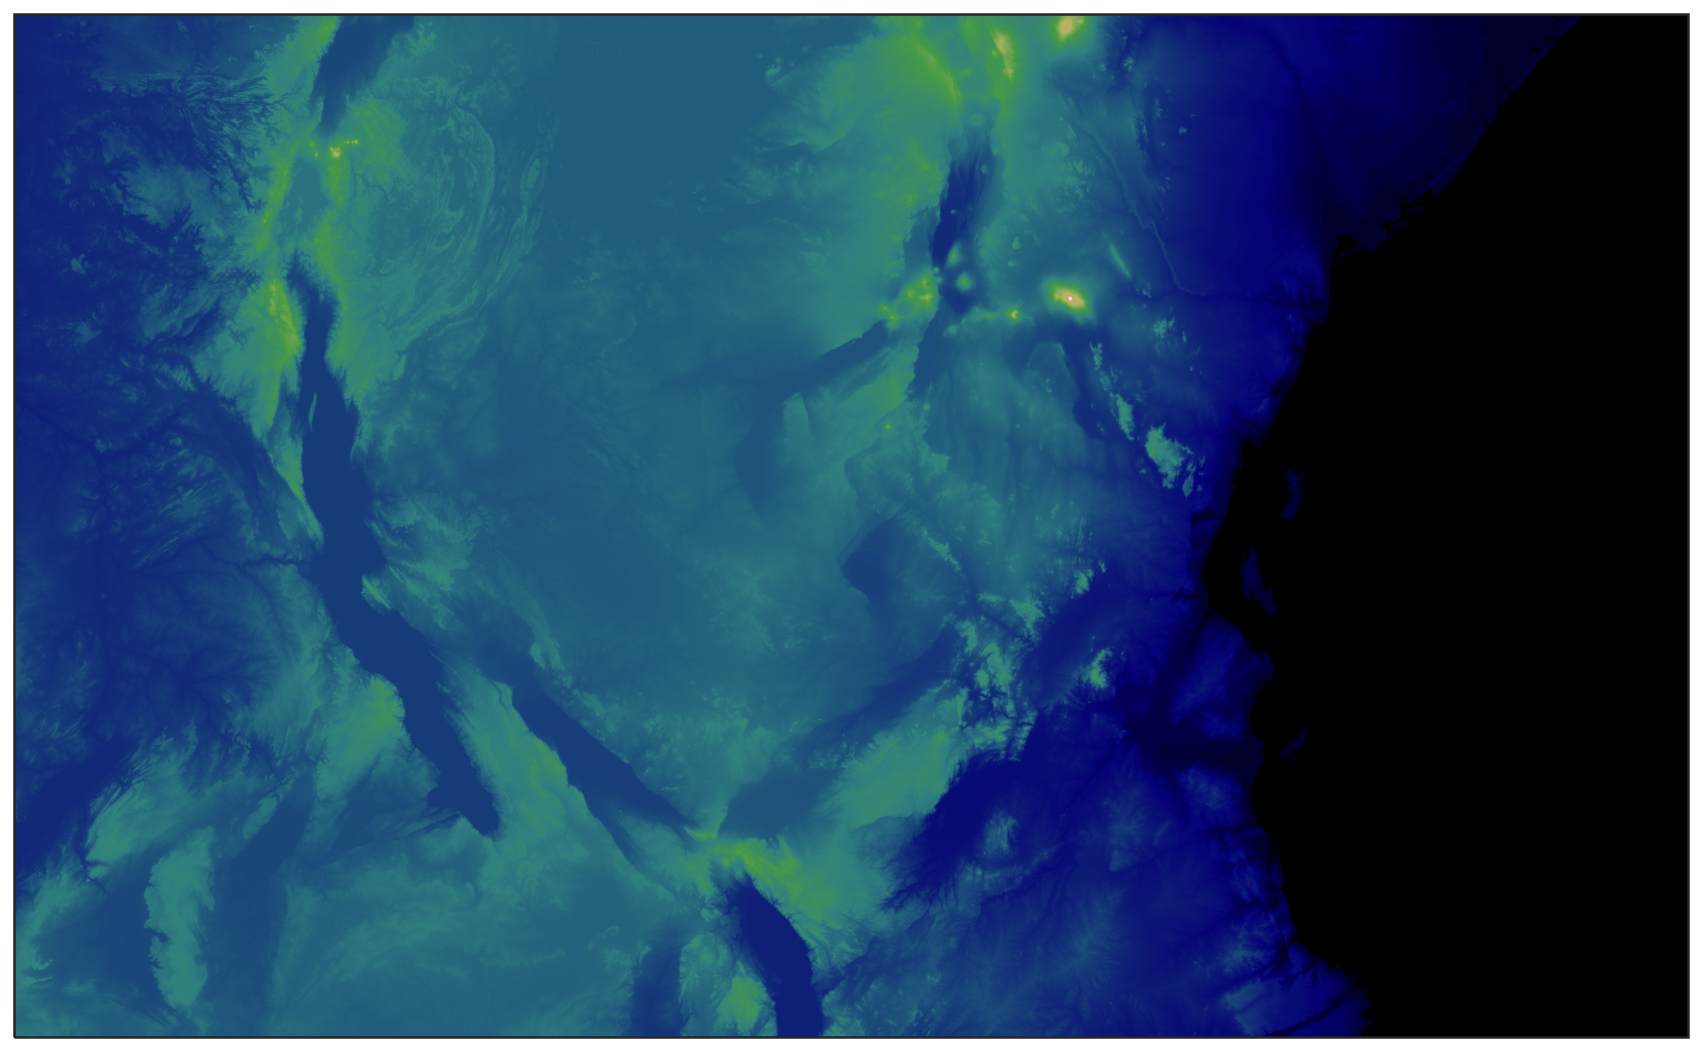

In [61]:
## Subplot 2: STRM Map
#from cartopy.io.srtm import srtm_composite
from cartopy.io.srtm import SRTM3Source


plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

min_lon, max_lon = 26, 44
min_lat, max_lat = -11, 0

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    lon_list = []
    for lon in range(min_lon, max_lon):
        lat_list = []
        for lat in range(min_lat, max_lat):
            elev, crs, extent = SRTM3Source().combined(lon, lat, 1, 1)
            lat_list.append(elev)
        lon_list.append(np.ma.concatenate(lat_list, axis=0))
    elev = np.ma.concatenate(lon_list, axis=1)

extent = (min_lon, max_lon, min_lat, max_lat)    
ax.imshow(elev, extent=extent, transform=crs, cmap='gist_earth', origin='lower') ;

In [62]:
x, y = np.gradient(elev)

slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))

# -x here because of pixel orders in the SRTM tile
aspect = np.arctan2(-x, y)

altitude = np.pi / 4.
azimuth = np.pi / 2.

shaded = np.sin(altitude) * np.sin(slope)\
    + np.cos(altitude) * np.cos(slope)\
    * np.cos((azimuth - np.pi/2.) - aspect)

## Shaded relief of East Africa

In [63]:
mycols = sns.color_palette(['#33a02c', '#FFB100', "#8d9da3", '#1f78b4', '#e31a1c', '#b15928'])
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.2, 0.6274509803921569, 0.17254901960784313),
 (1.0, 0.6941176470588235, 0.0),
 (0.5529411764705883, 0.615686274509804, 0.6392156862745098),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [78]:
gdf = gpd.GeoDataFrame(meta_data, geometry=gpd.points_from_xy(meta_data.longitude, meta_data.latitude)).loc[lambda df: df.Species != 'gelada']
gdf.loc[gdf.Species == 'ursinus (grayfoot)', 'Species'] = 'ursinus'

geo_loc = (gdf[['Origin', 'Species', 'Sex', 'geometry']]
           .dissolve(by=["Origin", 'Species'], 
                     aggfunc='count').rename(columns={'Sex': 'nr_samples'})
           .reset_index()
          )
geo_loc.head()

Origin    Species                    geometry  nr_samples
0      Aberdare, Kenya     anubis   POINT (36.71245 -0.41025)           0
1     Arusha, Tanzania     anubis   POINT (36.68808 -3.36968)           4
2      Awash, Ethiopia  hamadryas    POINT (40.16767 8.99250)           2
3       Chunga, Zambia     kindae  POINT (28.24438 -15.35811)          28
4  Dendro Park, Zambia    ursinus  POINT (26.06255 -16.14544)           4

Cutout box:

In [81]:
from shapely.geometry import Point, Polygon
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay

box = Polygon([(min_lon, min_lat), (max_lon, min_lat), 
               (max_lon, max_lat), (min_lon, max_lat)])

box_gdf = GeoDataFrame([{'geometry': box}])
box_gdf.plot() ;

In [101]:
geo_loc_box = geo_loc.overlay(box_gdf, how="intersection")
geo_loc_box
ranges_gdf_box = ranges_gdf.overlay(box_gdf, how="intersection")
ranges_gdf_box

/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/geopandas/geodataframe.py:2352: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.overlay(


ASSESSMENT       ID_NO            BINOMIAL  PRESENCE  ORIGIN  SEASONAL  \
0  17953200.0     40647.0        Papio anubis         1       1         1   
1  92251260.0  92250442.0  Papio cynocephalus         1       1         1   
2  92251260.0  92250442.0  Papio cynocephalus         1       1         1   
3  92252258.0    136848.0        Papio kindae         1       1         1   

         COMPILER  YEAR                                           CITATION  \
0  Janette Wallis  2020  Janette Wallis and IUCN (International Union f...   
1  Janette Wallis  2020  Janette Wallis and IUCN (International Union f...   
2  Janette Wallis  2020  Janette Wallis and IUCN (International Union f...   
3            IUCN  2020  IUCN (International Union for Conservation of ...   

              LEGEND    SUBSPECIES SUBPOP DIST_COMM ISLAND TAX_COMM  \
0  Extant (resident)          None   None      None   None     None   
1  Extant (resident)  cynocephalus   None      None   None     None   
2  Extant (resident)       ibeanus   None      None   None     None   
3  Extant (resident)          None   None      None   None     None   

                                            geometry  
0  MULTIPOLYGON (((39.40112 -0.54986, 38.57699 -1...  
1  MULTIPOLYGON (((30.75556 -8.16574, 30.52182 -7...  
2  POLYGON ((42.89045 -0.00013, 42.88994 -0.00013...  
3  POLYGON ((28.82770 -5.71846, 29.32611 -5.70747...

In [114]:
def scale_bar(ax, length=None, location=(0.5, 0.03), linewidth=1, color='black', zorder=None):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color=color, linewidth=linewidth, zorder=zorder)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc, color=color,
            horizontalalignment='center', verticalalignment='bottom', zorder=zorder)

/var/folders/33/sv_s_4ps2gjgpwdxjvz9jly00000gn/T/ipykernel_56300/2685751380.py:15: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
/Users/kmt/miniconda3/envs/maps/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


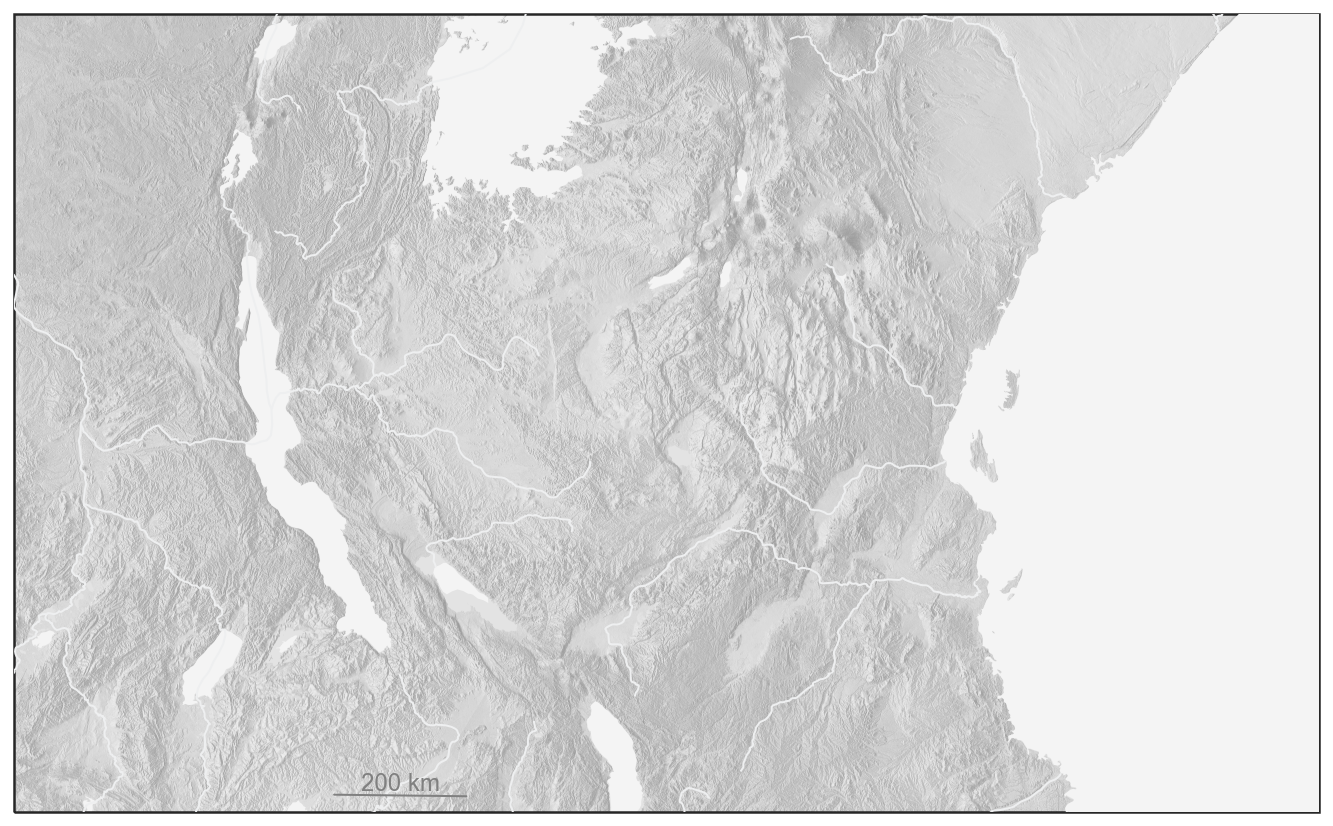

In [120]:
plt.figure(figsize=(12, 12 * (max_lat-min_lat)/(max_lon-min_lon)), 
#             linewidth=10, edgecolor='#33a02c'
          )
ax = plt.subplot(111, projection=ccrs.PlateCarree())

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridisBig = cm.get_cmap('gray', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.6, 0.95, 256)))

ax.imshow(shaded, extent=extent, transform=crs, cmap=newcmp, origin='lower', zorder=1) 

ax.add_feature(cartopy.feature.LAKES, facecolor='#F4F4F4', linewidth=0, zorder=2)
ax.add_feature(cartopy.feature.OCEAN, facecolor='#F4F4F4', linewidth=0, zorder=3)
ax.add_feature(cartopy.feature.RIVERS, color='#EEEFF0', linewidth=1, zorder=4)
# ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', edgecolor='#939598',
#                                                    facecolor='none',
#                                                    linewidth=1,
#                                                    zorder=5,
#                                                    scale='10m'))

# ax.scatter([30], [-5], s=100, transform=crs, zorder=4)

scale_bar(ax, zorder=6, color='grey', location=(0.3, 0.03))

####################
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import mpl_toolkits.axes_grid1.axes_size as Size

# def plot_pie_inset(data,ilon,ilat,ax,width,lon_offset=0, lat_offset=0):
    
#     if lon_offset or lat_offset:
#         ax.scatter(ilon, ilat, color='black', zorder=50, s=35)

#     ax_sub= inset_axes(ax, width=width, height=width, loc=10, 
#                        bbox_to_anchor=(ilon+lon_offset, ilat+lat_offset),
#                        bbox_transform=ax.transData, 
#                        borderpad=0)

#     if lon_offset or lat_offset:
#         ax.annotate("", xy=(ilon,ilat), xytext=(ilon+lon_offset,ilat+lat_offset), 
#                     arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=8, shrink=.1))
    
#     wedges,texts= ax_sub.pie(data, 
# #                              explode=(0, 0.3, 0), 
#                              startangle=0,
#                              colors=mycols,
#                              wedgeprops={"edgecolor":"black", 'linewidth': 0}
#                             )

#     ax_sub.set_aspect("equal")

# # lon_lat_coords = [(30, -7), (40, -2)]  
# lon_lat_coords = list(zip(geo_loc_box.geometry.x, geo_loc_box.geometry.y))
                  
# pie_lon_lat_coords = lon_lat_coords # get_pie_posistions(lon_lat_coords, ax, k=30, seed=2)
    
# for point, pie in zip(lon_lat_coords, pie_lon_lat_coords):
#     point_x, point_y = point
#     pie_x, pie_y = pie
#     plot_pie_inset([0.2, 0.75, 0.05],point_x,point_y,ax,0.6, 
#                    lon_offset=pie_x-point_x, lat_offset=pie_y-point_y)
####################


plt.savefig('shadedrelief.pdf', bbox_inches='tight')

## Small Africa map with ranges

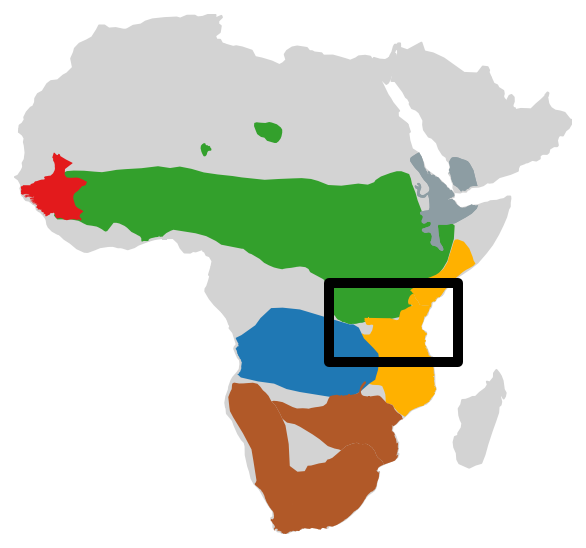

In [92]:
geodata_dir = Path('../baboon_range_data')
ranges_gdf = pd.concat(gpd.read_file(path) for path in geodata_dir.glob('**/*.shp'))

world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
world.columns

world_midres = gpd.read_file(
    '../natural_earth/50m_cultural/ne_50m_admin_0_countries.shp'
)
world_midres.columns
world_midres['continent'] = world_midres.CONTINENT
world_midres['name'] = world_midres.NAME_EN

# africa = world[world.continent == 'Africa']
africa = world[(world.continent == 'Africa') | (world.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]
africa_midres = world_midres[(world_midres.continent == 'Africa') | (world_midres.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]

plt.figure(figsize=(5, 5))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax = gplt.polyplot(africa, ax=ax, facecolor='lightgray', edgecolor='lightgray')
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=False
) ;


box = Polygon([(min_lon, min_lat), (max_lon, min_lat), 
               (max_lon, max_lat), (min_lon, max_lat)])

ax.add_geometries([box], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=5) ; 

plt.savefig('small_africa.pdf')